In [1]:
#Installing PySHP to read data from city districts, pyproj to convert geolocation data
# importing libraries
!pip install PyShp, pyproj
import shapefile as shp
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Proj
from sklearn.cluster import KMeans
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

In [3]:
# Reading shapefiles. 
# Files located in the following addresses:
# https://github.com/cmakemesay/Coursera_Capstone/blob/main/DEINFO_DISTRITO.dbf
# https://github.com/cmakemesay/Coursera_Capstone/blob/main/DEINFO_DISTRITO.shp
dbf_path = 'DEINFO_DISTRITO.dbf'
dbf = shp.Reader(dbf_path)
sf_path = 'DEINFO_DISTRITO.shp'
sf = shp.Reader(sf_path)

In [8]:
#Defining a function to read shapefile
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in dbf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [10]:
#Number of neighborhoods
df = read_shapefile(sf)
df.shape

(96, 10)

In [11]:
#Head of dataframe
df.head()

,CLASSID,FEATID,REVISIONNU,NOME_DIST,SIGLA_DIST,COD_DIST,COD_SUB,DATA_CRIAC,USUARIO_ID,coords
0,4.0,8583485.0,1.0,JOSE BONIFACIO,JBO,47,27,2007-03-19,0.0,"[(352436.869, 7394174.148), (352450.74, 739417..."
1,4.0,8583484.0,1.0,JD SAO LUIS,JDS,46,18,2007-03-19,0.0,"[(320696.639014, 7383620.281623), (320699.4863..."
2,4.0,8583445.0,1.0,ARTUR ALVIM,AAL,5,21,2007-03-19,0.0,"[(349461.276378, 7397764.525126), (349461.935,..."
3,4.0,8583479.0,1.0,JAGUARA,JAG,40,08,2007-03-19,0.0,"[(320731.080013, 7400614.591998), (320732.3860..."
4,4.0,8583437.0,1.0,VILA PRUDENTE,VPR,93,29,2007-03-19,0.0,"[(338651.038931, 7392203.484133), (338654.0335..."


In [12]:
# finding central location for each neighborhood

def averageloc(row):
    xloc = 0
    yloc = 0
    for j in range(0,len(row)):
        xloc = xloc + row[j][0]
        yloc = yloc + row[j][1]
    
    xloc = xloc/len(row)
    yloc = yloc/len(row)
    
    return xloc, yloc

for i in range(0,len(df)):
    locs = averageloc(df.loc[i,'coords'])
    df.loc[i,'Latitude'] = locs[0]
    df.loc[i,'Longitude'] = locs[1]

In [13]:
# Dataframe with added average location
df.head()

,CLASSID,FEATID,REVISIONNU,NOME_DIST,SIGLA_DIST,COD_DIST,COD_SUB,DATA_CRIAC,USUARIO_ID,coords,Latitude,Longitude
0,4.0,8583485.0,1.0,JOSE BONIFACIO,JBO,47,27,2007-03-19,0.0,"[(352436.869, 7394174.148), (352450.74, 739417...",354116.252457,7.392827e+06
1,4.0,8583484.0,1.0,JD SAO LUIS,JDS,46,18,2007-03-19,0.0,"[(320696.639014, 7383620.281623), (320699.4863...",321643.543276,7.381710e+06
2,4.0,8583445.0,1.0,ARTUR ALVIM,AAL,5,21,2007-03-19,0.0,"[(349461.276378, 7397764.525126), (349461.935,...",348337.423845,7.396216e+06
3,4.0,8583479.0,1.0,JAGUARA,JAG,40,08,2007-03-19,0.0,"[(320731.080013, 7400614.591998), (320732.3860...",321165.491331,7.399112e+06
4,4.0,8583437.0,1.0,VILA PRUDENTE,VPR,93,29,2007-03-19,0.0,"[(338651.038931, 7392203.484133), (338654.0335...",339826.335973,7.390279e+06


In [14]:
# Cleaning up table
neigh = df[['NOME_DIST','SIGLA_DIST','Latitude','Longitude']]
neigh.head()

,NOME_DIST,SIGLA_DIST,Latitude,Longitude
0,JOSE BONIFACIO,JBO,354116.252457,7.392827e+06
1,JD SAO LUIS,JDS,321643.543276,7.381710e+06
2,ARTUR ALVIM,AAL,348337.423845,7.396216e+06
3,JAGUARA,JAG,321165.491331,7.399112e+06
4,VILA PRUDENTE,VPR,339826.335973,7.390279e+06


In [16]:
# Convert coordinates to latitude and longitude
SPProj = Proj("+proj=utm +zone=23K, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
lon, lat = SPProj(neigh['Latitude'].values,neigh['Longitude'].values, inverse=True)
lat[0:5]

In [18]:
# Adding converted values to table
for i in range(0,len(neigh)):
    neigh.iloc[i,-2] = lat[i]
    neigh.iloc[i,-1] = lon[i]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [19]:
# Table with appropriade latitude and longitude values
neigh.head()

,NOME_DIST,SIGLA_DIST,Latitude,Longitude
0,JOSE BONIFACIO,JBO,-23.568415,-46.429467
1,JD SAO LUIS,JDS,-23.665530,-46.748884
2,ARTUR ALVIM,AAL,-23.537279,-46.485733
3,JAGUARA,JAG,-23.508364,-46.751482
4,VILA PRUDENTE,VPR,-23.590067,-46.569724


In [20]:
#Getting information from Foursquare
# Defining the function for importing venues from Foursquare
CLIENT_ID = 'TZYXMFXRER3PVD1AWMBQUCH2W5VDWXYBFWR5UANOU3O2HIFX' # your Foursquare ID
CLIENT_SECRET = 'U2MGQUCKP52GCPCC31Z1Q2USRWJ5T3R1K3IGRZFRH5K4XKBW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


def getNearbyVenues(names, latitudes, longitudes, code, radius=1600):
    
    venues_list=[]
    for code, name, lat, lng in zip(code, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            code,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Code','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
#Using function to retrieve venues from Foursquare API
sp_venues = getNearbyVenues(names=neigh['NOME_DIST'], latitudes=neigh['Latitude'], longitudes=neigh['Longitude'], code = neigh['SIGLA_DIST'])

JOSE BONIFACIO
JD SAO LUIS
ARTUR ALVIM
JAGUARA
VILA PRUDENTE
JAGUARE
JARAGUA
JD HELENA
JD PAULISTA
LAJEADO
LAPA
LIBERDADE
LIMAO
VILA MEDEIROS
JD ANGELA
PARELHEIROS
VILA SONIA
AGUA RASA
ALTO DE PINHEIROS
ANHANGUERA
ARICANDUVA
BARRA FUNDA
BELA VISTA
BELEM
BOM RETIRO
BRAS
BRASILANDIA
BUTANTA
CACHOEIRINHA
CAMBUCI
CAMPO BELO
CAMPO GRANDE
CAMPO LIMPO
CANGAIBA
CAPAO REDONDO
CARRAO
CASA VERDE
CID ADEMAR
CID DUTRA
CID LIDER
CID TIRADENTES
CONSOLACAO
CURSINO
ERMELINO MATARAZZO
FREGUESIA DO O
GRAJAU
GUAIANASES
IGUATEMI
IPIRANGA
ITAIM BIBI
ITAIM PAULISTA
ITAQUERA
JABAQUARA
JACANA
MANDAQUI
MARSILAC
MOEMA
MOOCA
MORUMBI
PARI
PARQUE DO CARMO
PEDREIRA
PENHA
PERDIZES
PERUS
PINHEIROS
PIRITUBA
PONTE RASA
RAPOSO TAVARES
RIO PEQUENO
SACOMA
SANTANA
SANTO AMARO
SAO DOMINGOS
SAO LUCAS
SAO MATEUS
SAO MIGUEL
SAO RAFAEL
SAPOPEMBA
SAUDE
SE
SOCORRO
TATUAPE
TREMEMBE
TUCURUVI
VILA ANDRADE
VILA CURUCA
VILA FORMOSA
VILA GUILHERME
VILA JACUI
VILA LEOPOLDINA
VILA MARIA
VILA MARIANA
VILA MATILDE
SANTA CECILIA
REPUBLICA


In [22]:
#Size of retrieved table
sp_venues.shape

(7105, 8)

In [23]:
#Head of table
sp_venues.head()

,Code,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,JBO,JOSE BONIFACIO,-23.568415,-46.429467,Kodomo-no-Sono,-23.566109,-46.428694,Japanese Restaurant
1,JBO,JOSE BONIFACIO,-23.568415,-46.429467,Galpão das Plantas,-23.572315,-46.442596,Flower Shop
2,JBO,JOSE BONIFACIO,-23.568415,-46.429467,Roldão Atacadista,-23.564515,-46.415218,Big Box Store
3,JBO,JOSE BONIFACIO,-23.568415,-46.429467,Batata,-23.554245,-46.428270,Food Truck
4,JBO,JOSE BONIFACIO,-23.568415,-46.429467,Supermercado Ricoy,-23.563833,-46.416634,Grocery Store


In [35]:
# Making table with number of venue categories per neighborhood
typevenues = sp_venues.groupby('Neighborhood')['Venue Category'].nunique()
typevenues

Neighborhood
AGUA RASA            59
ALTO DE PINHEIROS    60
ANHANGUERA           12
ARICANDUVA           30
ARTUR ALVIM          53
                     ..
VILA MARIANA         62
VILA MATILDE         39
VILA MEDEIROS        51
VILA PRUDENTE        55
VILA SONIA           55
Name: Venue Category, Length: 95, dtype: int64

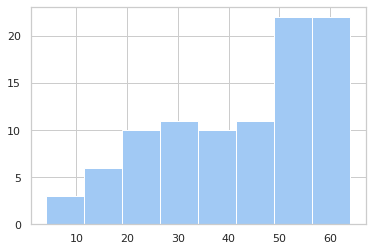

In [37]:
# Making histogram with this data
plt.hist(typevenues, bins='auto')
plt.show()

We see that most neighborhoods have a good variety of venues close to them, while a good part of the districts has less. Some neighborhoods have very little diversity in the type of venues found in this analysis

In [79]:
# Grouping neighborhoods by number of venues found and number of types of venues
numtype = pd.DataFrame(columns=['Neighborhood','Number of Venues','Types of Venues'])
numtype['Neighborhood'] = np.sort(sp_venues['Neighborhood'].unique())
numtype['Number of Venues'] = list(sp_venues.groupby('Neighborhood')['Venue Category'].count())
numtype['Types of Venues'] = list(sp_venues.groupby('Neighborhood')['Venue Category'].nunique())
numtype.head()

,Neighborhood,Number of Venues,Types of Venues
0,AGUA RASA,100,59
1,ALTO DE PINHEIROS,100,60
2,ANHANGUERA,15,12
3,ARICANDUVA,53,30
4,ARTUR ALVIM,100,53


In [83]:
# Grouping neighborhoods according to this data using k-means, and 3 clusters
kclusters = 3
spnumvenues = numtype.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters = kclusters, init='k-means++',n_init=12).fit(spnumvenues)

numtype['Label'] = kmeans.labels_

numtype.head()

,Neighborhood,Number of Venues,Types of Venues,Label
0,AGUA RASA,100,59,0
1,ALTO DE PINHEIROS,100,60,0
2,ANHANGUERA,15,12,1
3,ARICANDUVA,53,30,2
4,ARTUR ALVIM,100,53,0


In [111]:
# Adding latitude and longitude data
for i in range(0,len(numtype)):
    numtype.loc[i,'Latitude'] = list(neigh[neigh['NOME_DIST'] == numtype.loc[i,'Neighborhood']]['Latitude'])
    numtype.loc[i,'Longitude'] = list(neigh[neigh['NOME_DIST'] == numtype.loc[i,'Neighborhood']]['Longitude'])

In [90]:
#Finding center of city
latitude = numtype['Latitude'].mean()
longitude = numtype['Longitude'].mean()

In [120]:
# Mapping neighborhoods with labels
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(numtype['Latitude'], numtype['Longitude'], numtype['Neighborhood'], numtype['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


In [119]:
# Check which neighborhood did not appear in analysis
for item in list(neigh['NOME_DIST']):
    if item not in list(numtype['Neighborhood']):
        print(item)

MARSILAC


Marsilac did not appear in the map. The southern zone of São Paulo is sparsely populated and has environmental protection areas.

In [139]:
# Setting up a table with the types of venues
sp_onehot = pd.get_dummies(sp_venues[['Venue Category']], prefix ="", prefix_sep="")
sp_onehot['District'] = sp_venues['Neighborhood']
fixed_columns = [sp_onehot.columns[-1]] + list(sp_onehot.columns[:-1])
sp_onehot = sp_onehot[fixed_columns]

sp_onehot.head()

,District,Acai House,Accessories Store,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Arepa Restaurant,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,JOSE BONIFACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,JOSE BONIFACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,JOSE BONIFACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,JOSE BONIFACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,JOSE BONIFACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
#Grouping by neighborhood
pd.options.display.float_format = '{:,.3f}'.format
sp_grouped = sp_onehot.groupby('District').mean().reset_index()
sp_grouped.head()

,District,Acai House,Accessories Store,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Arepa Restaurant,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,AGUA RASA,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.000,0.000
1,ALTO DE PINHEIROS,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.010,0.000
2,ANHANGUERA,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,ARICANDUVA,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,ARTUR ALVIM,0.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,VILA MARIANA,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.000,0.010
91,VILA MATILDE,0.014,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
92,VILA MEDEIROS,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000
93,VILA PRUDENTE,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [175]:
# Grouping these neighborhoods in 6 clusters using k-means
kclusters = 6

sp_grouped_clustering = sp_grouped.drop('District',1)

kmeans = KMeans(n_clusters = kclusters, init='k-means++',n_init=50).fit(sp_grouped_clustering)

numtype['Label 2'] = kmeans.labels_

numtype.head()

,Neighborhood,Number of Venues,Types of Venues,Label,Latitude,Longitude,Label 2
0,AGUA RASA,100,59,0,-23.566,-46.572,0
1,ALTO DE PINHEIROS,100,60,0,-23.543,-46.706,1
2,ANHANGUERA,15,12,1,-23.433,-46.792,4
3,ARICANDUVA,53,30,2,-23.576,-46.515,4
4,ARTUR ALVIM,100,53,0,-23.537,-46.486,4


In [199]:
# create map
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(numtype['Latitude'], numtype['Longitude'], numtype['Neighborhood'], numtype['Label 2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

Apparently three neighborhoods are acting as outliers in this analysis: Tremembé (northern part, close to a state park), Grajaú and Parelheiros (close to a dam and to environmental protection areas). Let's exclude them from our analysis

In [197]:
#Removing rows
numtype2 = numtype.set_index('Neighborhood').drop(['GRAJAU','PARELHEIROS','TREMEMBE'])
numtype2.reset_index(inplace=True)
sp_grouped_clustering2 = sp_grouped.set_index('District').drop(['GRAJAU','PARELHEIROS','TREMEMBE']).reset_index().drop('District',1)
# Grouping these neighborhoods in 6 clusters using k-means
kclusters = 6

kmeans = KMeans(n_clusters = kclusters, init='k-means++',n_init=50).fit(sp_grouped_clustering2)

numtype2['Label 2'] = kmeans.labels_

numtype2.head()

,Neighborhood,Number of Venues,Types of Venues,Label,Latitude,Longitude,Label 2
0,AGUA RASA,100,59,0,-23.566,-46.572,2
1,ALTO DE PINHEIROS,100,60,0,-23.543,-46.706,5
2,ANHANGUERA,15,12,1,-23.433,-46.792,3
3,ARICANDUVA,53,30,2,-23.576,-46.515,3
4,ARTUR ALVIM,100,53,0,-23.537,-46.486,5


In [198]:
#Plotting map again
# create map
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(numtype2['Latitude'], numtype2['Longitude'], numtype2['Neighborhood'], numtype2['Label 2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2
